In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import csv
from data_preparation  import preprocess_field_data, prepro_data_kl
from hsic import HSIC
import json
import matplotlib.pyplot as plt
from mcmc_integration import BayesCalibrationMCMC
from metamodels import VPCEMetamodel, KarhunenLoeveMetamodel, GpMetamodelInd
import numpy as np
import openturns as ot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pickle
import pandas as pd
from plot import plot_tpd


BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/d8/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

plt.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = True

In [2]:
def kl_div(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

# Methodology implementation

In [3]:
mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/d8/doe_cl.npy', allow_pickle=True)

n_max = mc_hl.shape[0]
n_samp = 1000
input_dimension = 8


In [4]:
#Base metamodel
X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
GP = GpMetamodelInd(trend='Constant', kernel='AbsExp', input_dimension=(input_dimension-1))
full_metamodel = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=SIMULATION_TIME)
full_metamodel.fit(X_train, y_train)

11 nan trajectories in output sample
Running Karhunen-Loeve decomposition
Explained variance for 2 modes is 0.999998157762496
Done fitting mode 1
Done fitting mode 2


WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


In [5]:
r2_score = full_metamodel.r2_score(X_test, y_test, SIMULATION_TIME)

In [6]:
#Individual variable scalers
x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
scalers = []
for i in range(x.shape[1]):
    scaler = StandardScaler()
    scaler.fit(x[:,i].reshape(-1,1))
    scalers.append(scaler)

11 nan trajectories in output sample


In [7]:
#Prior distributions
alpha = ot.Uniform(100.0, 103.0)
beta = ot.Uniform(0.02, 0.025)
eps_e = ot.Uniform(0.2, 0.5)
eps_c = ot.Uniform(0.01, 0.3)
d_p = ot.Uniform(0.5e-6, 10.0e-6)
g_p0 = ot.Uniform(1.0e-9, 8.0e-9)
a_v = ot.Uniform(0.0, 15e-4)

marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]

prior = ot.ComposedDistribution(marginals)

In [8]:
data_without_time_division, _ = preprocess_field_data(csv_file=csv_file, 
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=False)

data_with_time_division, time_indices = preprocess_field_data(csv_file=csv_file,
                                operation_time=SIMULATION_TIME, 
                                cleaning_dates=cleaning_dates, 
                                with_time_division=True)

In [45]:
threshold = 1e-7
N = 10000

#Metamodels 
TRENDS = ['Constant', 'Linear', 'Quad']
COVS = ['AbsExp', 'SqExp', 'M-1/2', 'M-3/2', 'M-5/2']

#MCMC parameters
step_sizes = [10, 0.01, 0.01, 0.05, 5e-6, 1.5e-9, 1e-3]
proposal_distribution = [ot.Uniform(-step, step) for step in step_sizes]

posterior_distributions = []

ot.RandomGenerator.SetSeed(42)
for i in range(3):

    #reset the prior distribution
    X, y, SCALER = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=True)
    marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]
    x, _ = prepro_data_kl(mc_hl, mc_cl, n_max, n_samp, input_dimension, scale=False)
    scalers = []
    for k in range(x.shape[1]):
        scaler = StandardScaler()
        scaler.fit(x[:,k].reshape(-1,1))
        scalers.append(scaler)

    print('Starting assimilation for CC cycle ', i+1)

    while True:

        y_interpolated = np.asarray([np.interp(data_without_time_division[:,0]*24, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

        X_train, X_test, y_train_int, y_test_int = train_test_split(X, y_interpolated, train_size=0.75, random_state=42)

        #Compute the max HSIC index
        hsic = HSIC(ot.Sample(X), ot.Sample(y))
        r2_hsic, _ = hsic.r2_hsic()
        index = int(np.where(max(r2_hsic.mean(axis=1)) == r2_hsic.mean(axis=1))[0][0])
        print('HSIC max is for index = ', (index+1))

        # Compute all the calibration metamodels
        print('Computing calibration metamodels')
        metamodels = []
        for trend in TRENDS:
            for cov in COVS:
                GP = GpMetamodelInd(trend=trend, kernel=cov, input_dimension=(input_dimension-1), index=index)
                KL_calibration = KarhunenLoeveMetamodel(metamodel=GP, input_dimension=input_dimension, simulation_time=data_without_time_division[:,0]*24, verbose=False)
                KL_calibration.fit(X_train, y_train_int)
                metamodels.append(KL_calibration)

        # GP scalers for the index variable
        all_scalers = [scalers[int(index)]]*(len(metamodels))

        # MCMC posterior distribution
        print('Running MCMC calibration')
        bayes_int = BayesCalibrationMCMC(data=data_with_time_division[i], data_time_indices=time_indices[i], metamodels=metamodels, scalers=all_scalers)

        posterior = bayes_int.mcmc_run(support_min=[marginals[index].getRange().getLowerBound()[0]], support_max=[marginals[index].getRange().getUpperBound()[0]], proposal=proposal_distribution[index], burning=100, n_chains=3, sample_size=1000, nb_weights=1000)

        # Compute the Kullback divergence
        posterior_samples = np.asarray(posterior.getSample(N)).reshape(-1)
        prior_samples = np.asarray(marginals[index].getSample(N)).reshape(-1)

        posterior_pdf, _ = np.histogram(posterior_samples, bins=100, density=True)
        prior_pdf, _ = np.histogram(prior_samples, bins=100, density=True)

        posterior_pdf = posterior_pdf / np.sum(posterior_pdf)
        prior_pdf = prior_pdf / np.sum(prior_pdf)

        kullback_divergence = kl_div(posterior_pdf, prior_pdf)
        print('Kullback-Leibler divergence = ', kullback_divergence)

        if kullback_divergence < threshold or kullback_divergence == np.inf:
            #the prior is fully informed by the data and the calibration is stopped
            posterior_distributions.append(marginals)
            break

        elif kullback_divergence > threshold:
            #modify the prior distribution
            marginals[index] = posterior
            prior = ot.ComposedDistribution(marginals)
            X = np.asarray(prior.getSample(n_max))
            #Update the scalers
            scalers = []
            for k in range(X.shape[1]):
                scaler = StandardScaler()
                scaler.fit(X[:,k].reshape(-1,1))
                scalers.append(scaler)
            #Update the design of experiments
            X = SCALER.transform(X)
            y = full_metamodel.predict(X)
            continue

11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  1
HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 10 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0000603779409774
Kullback-Leibler divergence =  1.5212754698955684


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.85096,6.8249,6.96702,7.00471,6.83626,6.90782,3.15954]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0054168614740635
Kullback-Leibler divergence =  1.3041189878205712


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.9214,6.81031,6.97207,7.02377,6.79716,4.92626,2.21828]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9996217648721697
Kullback-Leibler divergence =  0.325059106363226


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92665,6.82286,6.97529,7.00455,2.94881,4.76859,2.45442]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9994557757021669
Kullback-Leibler divergence =  0.5047160645059481


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  2
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90728,6.81279,6.97814,5.58082,2.83603,5.60212,4.62787]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9999526107347297
Kullback-Leibler divergence =  0.2287044874833175


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.88119,6.82494,6.9619,5.32086,2.79926,5.60212,3.01634]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0227215806427752
Kullback-Leibler divergence =  inf
11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  2


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]
WRN - (previous message repeated 6 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0067996296345065
Kullback-Leibler divergence =  0.9169596146508138


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91174,6.80593,6.96705,7.02907,6.81739,6.9157,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9995579030891583
Kullback-Leibler divergence =  0.43755376619687497


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.89733,6.82874,6.97423,7.0274,6.83711,6.07967,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0009678999741292
Kullback-Leibler divergence =  0.5574995974313384


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92248,6.7976,6.96217,7.01699,5.385,6.06165,1.49079]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0000868398793745
Kullback-Leibler divergence =  0.2690472384567545


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.89056,6.8273,6.95423,6.91473,5.91561,6.13695,2.02694]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0375293520253461
Kullback-Leibler divergence =  inf
11 nan trajectories in output sample
11 nan trajectories in output sample
Starting assimilation for CC cycle  3


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  7
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]
WRN - (previous message repeated 6 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.90359,6.82222,6.98139,7.00814,6.82393,6.86245,6.9168]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0039890994289997
Kullback-Leibler divergence =  2.0759754067703886


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 7 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92101,6.81843,6.96324,7.02882,6.81219,6.90872,3.21329]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0046105539498194
Kullback-Leibler divergence =  0.24942661532064403


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  6
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.92206,6.80929,6.94014,6.87952,6.82058,6.92354,3.0931]
WRN - (previous message repeated 13 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.92206,6.80929,6.94014,6.87952,6.82058,6.92354,3.0931]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 0.9995985923714722
Kullback-Leibler divergence =  0.3184636708521569


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  5
Computing calibration metamodels


WRN - Warning! For coherency we set scale upper bounds = [6.91091,6.82689,6.94299,6.87484,6.84249,6.28837,3.21329]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.007283596975894
Kullback-Leibler divergence =  0.39992234029485774


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.91663,6.81602,6.94475,6.89276,6.64362,6.28837,2.84531]
WRN - (previous message repeated 7 times)
WRN - TNC algorithm failed. The error message is Linear search failed
WRN - Warning! For coherency we set scale upper bounds = [6.91663,6.81602,6.94475,6.89276,6.64362,6.28837,2.84531]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.016234867138486
Kullback-Leibler divergence =  0.35509033631090575


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


HSIC max is for index =  2
Computing calibration metamodels


WRN - (previous message repeated 6 times)
WRN - Warning! For coherency we set scale upper bounds = [6.9006,6.7842,6.95245,5.4134,6.71367,6.27176,3.21329]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0019743929517908
Kullback-Leibler divergence =  0.17120299463688812
HSIC max is for index =  4
Computing calibration metamodels


WRN - (previous message repeated 14 times)
WRN - Warning! For coherency we set scale upper bounds = [6.90922,6.7965,6.95901,5.8807,6.71367,6.19412,2.53257]


Running MCMC calibration
Running Markov chain 0
Running Markov chain 1
Running Markov chain 2
Gelman-Rubin convergence diagnostic: 1.0058013695657093
Kullback-Leibler divergence =  inf


/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_14638/1849261530.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.where(a != 0, a * np.log(a / b), 0))


# Results visualization

In [46]:
posterior_distrib_dfs = []
for i in range(3):
    posterior_samples = np.asarray([np.asarray(posterior_distributions[i][j].getSample(1000)).reshape(-1) for j in range(len(posterior_distributions[i]))])
    posterior_distrib_df = pd.DataFrame(posterior_samples.T, columns=['X'+str(j) for j in range(1,8)])
    posterior_distrib_dfs.append(posterior_distrib_df)

In [47]:
with open('posterior_distrib_dfs.pkl', 'wb') as f:
    pickle.dump(posterior_distrib_dfs, f)

In [9]:
with open('posterior_distrib_dfs.pkl', 'rb') as f:
    posterior_distrib_dfs = pickle.load(f)

In [10]:
N = 1000
trajs = []
for i in range(3): 
    #trajs.append(full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(posterior_distributions[i]).getSample(N))))
    trajs.append(full_metamodel.predict(SCALER.transform(posterior_distrib_dfs[i])))


/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [11]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [12]:
traj = np.concatenate((trajs[0][:,:nc1+1], np.concatenate((trajs[1][:,nc1+1:nc2+1], trajs[2][:,nc2+1:]), axis=1)), axis=1)

In [13]:
marginals = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]
traj_prior = full_metamodel.predict(SCALER.transform(ot.ComposedDistribution(marginals).getSample(N)))


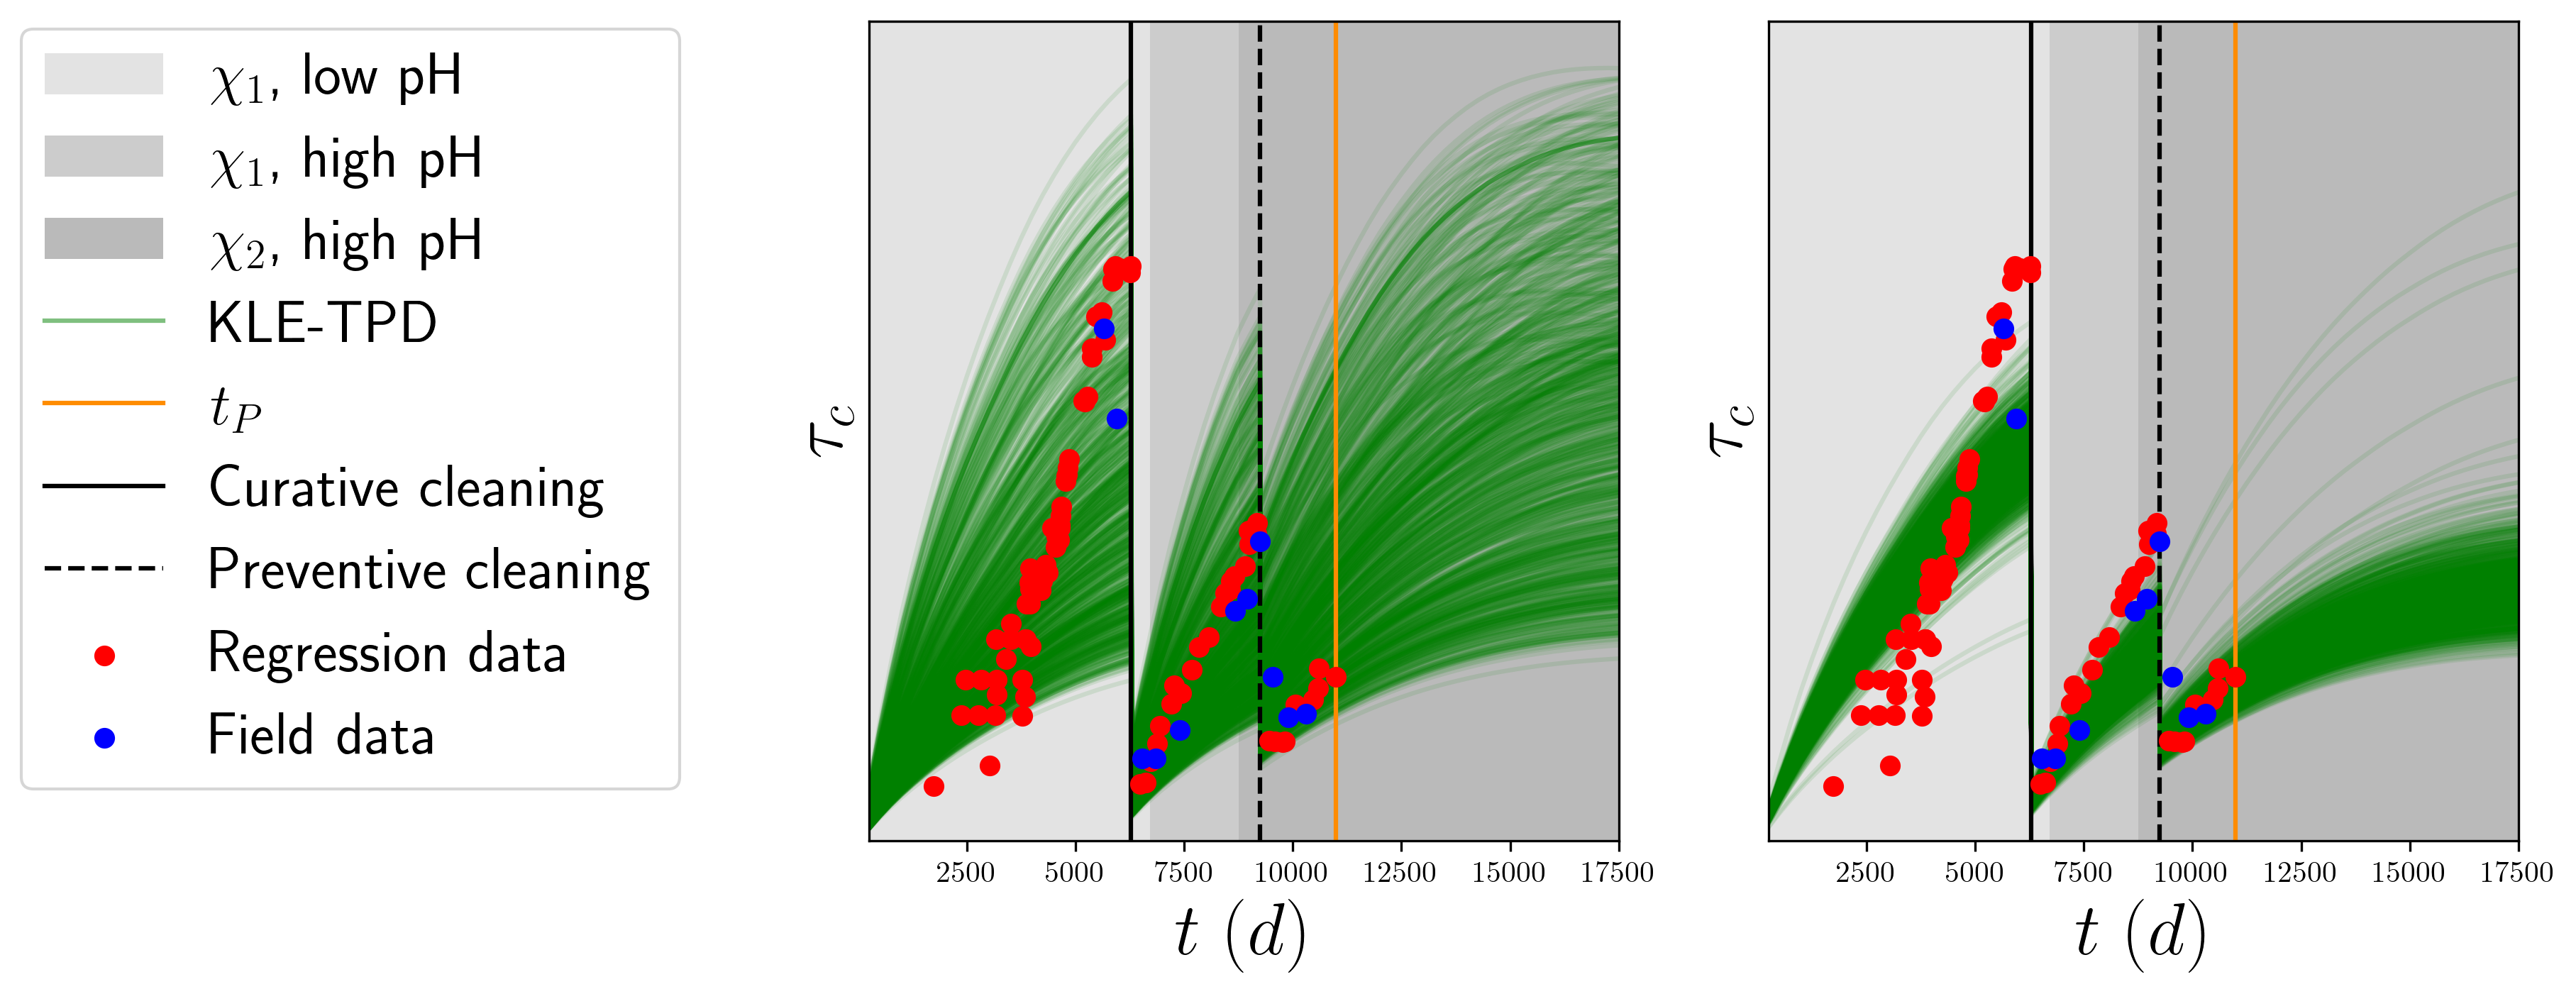

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0] = plot_tpd(axs[0], input_dic, traj_prior, SIMULATION_TIME, 'KLE-TPD')
axs[1] = plot_tpd(axs[1], input_dic, traj, SIMULATION_TIME, 'KLE-TPD')

for i in range(3):
    if i == 0:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', label='Field data', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
    else:
        axs[0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red',  zorder=10)
        axs[0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
        axs[1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)

axs[0].grid(False)
axs[1].grid(False)

axs[0].set_yticks([])
axs[1].set_yticks([])

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

#fig.suptitle(r'TPD-KL emulations with prior distributions and after assimilation', fontsize=20)

In [15]:
df_x1 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X1'], 'CC-PC': posterior_distrib_dfs[1]['X1'], 'PC': posterior_distrib_dfs[2]['X1']})
df_x2 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X2'], 'CC-PC': posterior_distrib_dfs[1]['X2'], 'PC': posterior_distrib_dfs[2]['X2']})
df_x3 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X3'], 'CC-PC': posterior_distrib_dfs[1]['X3'], 'PC': posterior_distrib_dfs[2]['X3']})
df_x4 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X4'], 'CC-PC': posterior_distrib_dfs[1]['X4'], 'PC': posterior_distrib_dfs[2]['X4']})
df_x5 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X5'], 'CC-PC': posterior_distrib_dfs[1]['X5'], 'PC': posterior_distrib_dfs[2]['X5']})
df_x6 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X6'], 'CC-PC': posterior_distrib_dfs[1]['X6'], 'PC': posterior_distrib_dfs[2]['X6']})
df_x7 = pd.DataFrame({'CC': posterior_distrib_dfs[0]['X7'], 'CC-PC': posterior_distrib_dfs[1]['X7'], 'PC': posterior_distrib_dfs[2]['X7']})
dfs = [df_x1, df_x2, df_x3, df_x4, df_x5, df_x6, df_x7]

/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_25514/3591719545.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_25514/3591719545.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_25514/3591719545.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//4, i%4].legend().set_visible(False)
/var/folders/gk/qw58r90s5mxbbktrp1w2mnth0000gp/T/ipykernel_25514/3591719545.py:12: UserWarning: No artists

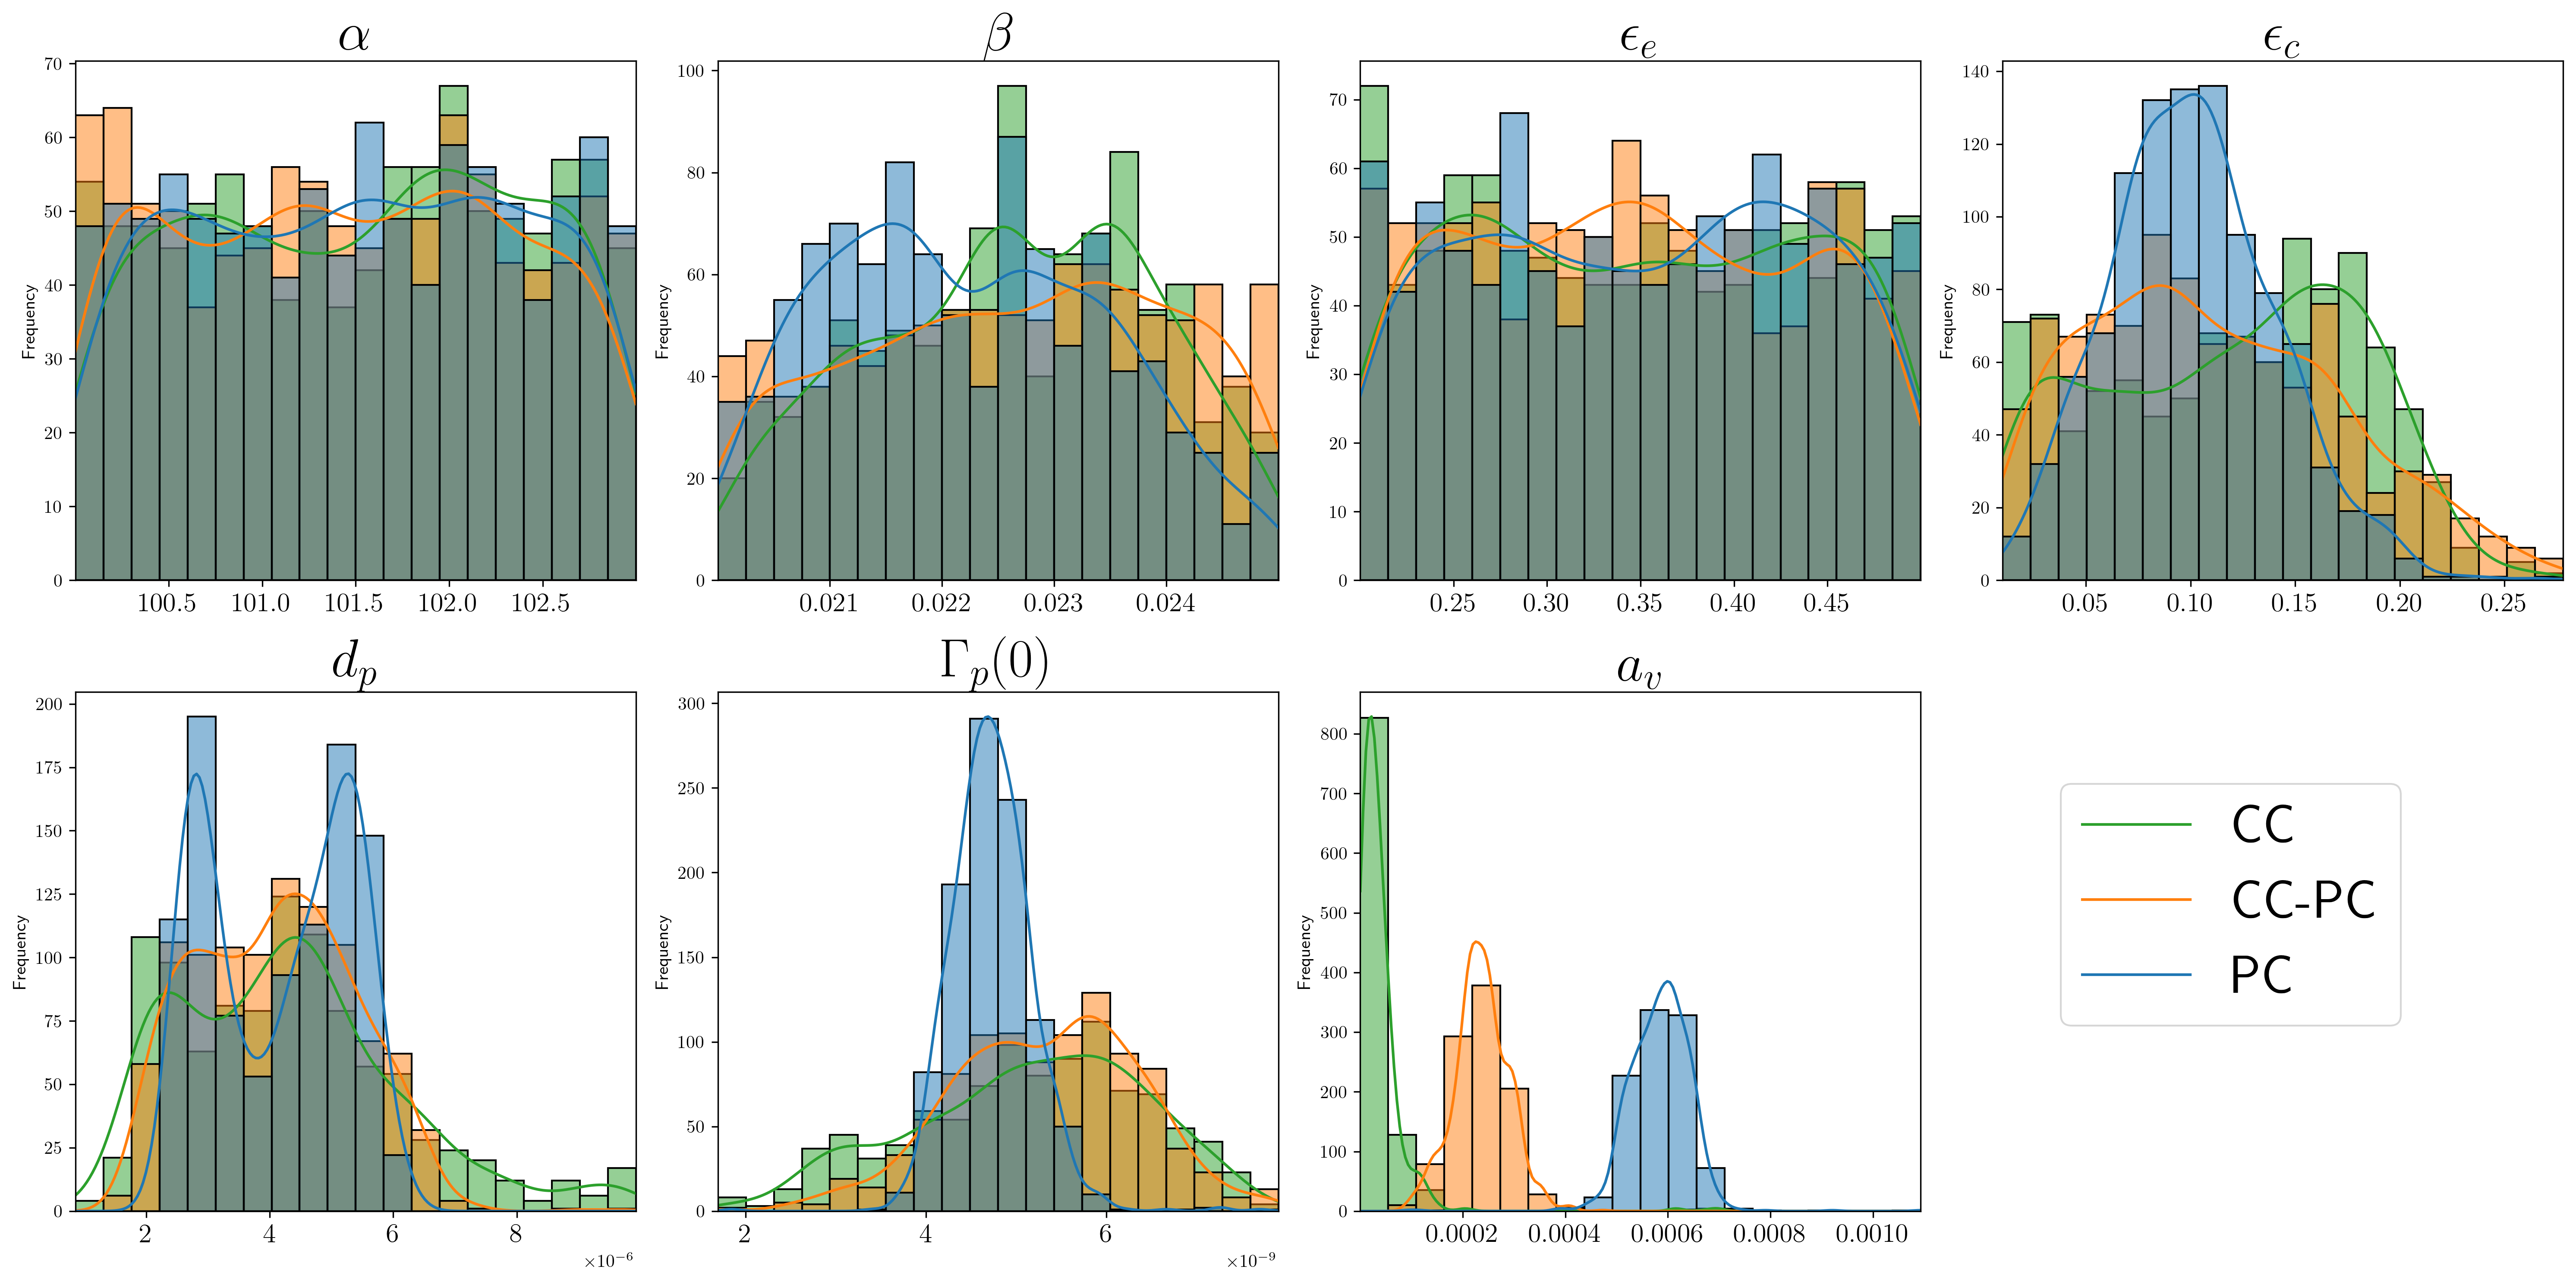

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
label = ['CC', 'CC-PC', 'PC']
titles = [r"$\alpha$", r"$\beta$", r"$\epsilon_e$", r"$\epsilon_c$", r"$d_p$", r"$\Gamma_{p}(0)$", r"$a_v$"]

for i in range(7):
    sns.histplot(dfs[i], ax=axs[i//4, i%4], bins=20, kde=True)
    axs[i//4, i%4].set_title(titles[i], fontsize=30)
    axs[i//4, i%4].set_xlabel('')
    axs[i//4, i%4].set_ylabel('Frequency')
    #axs[i//4, i%4].set_ylabel('')
    #axs[i//4, i%4].set_yticks([])
    axs[i//4, i%4].legend().set_visible(False)
    axs[i//4, i%4].set_xlim(dfs[i].min().min(), dfs[i].max().max())
    axs[i//4, i%4].tick_params(axis='x', labelsize=15)
fig.legend(labels=label, loc=(0.8,0.2), fontsize=30)
fig.delaxes(axs[1, 3])
plt.tight_layout()

# Kalman smoothing

In [17]:
obs_indices_1 = data_with_time_division[0][0].T[0].astype(int)
obs_indices_2 = data_with_time_division[1][0].T[0].astype(int)
obs_indices_3 = data_with_time_division[2][0].T[0].astype(int)

obs_values_1 = data_with_time_division[0][0].T[1]
obs_values_2 = data_with_time_division[1][0].T[1]
obs_values_3 = data_with_time_division[2][0].T[1]

obs_indices = [obs_indices_1, obs_indices_2, obs_indices_3]
obs_values = [obs_values_1, obs_values_2, obs_values_3]

cleaning_time_indices = np.asarray([np.where(SIMULATION_TIME == np.asarray(cleaning_dates).astype(int)[i])[0][0] for i in range(len(cleaning_dates))])


In [18]:
time_indices_1 = np.sort(np.concatenate([
	obs_indices_1,
	SIMULATION_TIME[:int(cleaning_time_indices[0])]
]))

time_indices_2 = np.sort(np.concatenate([
    obs_indices_2,
    SIMULATION_TIME[int(cleaning_time_indices[0]):int(cleaning_time_indices[1])]
]))

time_indices_3 = np.sort(np.concatenate([
    obs_indices_3,
    SIMULATION_TIME[int(cleaning_time_indices[1]):]
]))

time_indices_1 = time_indices_1.astype(int)
time_indices_2 = time_indices_2.astype(int)
time_indices_3 = time_indices_3.astype(int)

time_indices = [time_indices_1, time_indices_2, time_indices_3]

In [19]:
distribs, index_t = [], []
obs_std = 5 / 1.96
for k in range(3):
    time_ind = time_indices[k]
    obs_ind = obs_indices[k]
    obs_val = obs_values[k]
    kalman_gain, j = 0, 0
    ind = []
    for i in range(len(time_ind)):
        if time_ind[i] in obs_ind:
            print(f"Assimilating observation at time index {time_ind[i]}")
            j = np.where(obs_ind == time_ind[i])[0][0]
            ind.append(i)
        else:
            pass
    index_t.append(ind)
    

Assimilating observation at time index 1731
Assimilating observation at time index 2369
Assimilating observation at time index 2475
Assimilating observation at time index 2772
Assimilating observation at time index 2831
Assimilating observation at time index 3033
Assimilating observation at time index 3156
Assimilating observation at time index 3176
Assimilating observation at time index 3182
Assimilating observation at time index 3186
Assimilating observation at time index 3394
Assimilating observation at time index 3516
Assimilating observation at time index 3522
Assimilating observation at time index 3770
Assimilating observation at time index 3771
Assimilating observation at time index 3837
Assimilating observation at time index 3840
Assimilating observation at time index 3864
Assimilating observation at time index 3883
Assimilating observation at time index 3939
Assimilating observation at time index 3950
Assimilating observation at time index 3961
Assimilating observation at time

In [20]:
def ensemble_kalman_smoother(Y, obs_indices, obs_values, obs_std):
    """
    Y: ensemble trajectories, shape (N, T)
    obs_indices: list of observation time indices
    obs_values: list of observed values
    obs_std: scalar, standard deviation of observation noise
    """
    N, T = Y.shape
    R = obs_std**2

    for idx, t_obs in enumerate(obs_indices):
        obs = obs_values[idx]

        # Mean and anomalies
        m = np.mean(Y, axis=0)
        A = Y - m  # shape (N, T)
        # Cross-covariance and Kalman gain
        C_ty = (A.T @ A[:, t_obs]) / (N - 1)  # shape (T,)
        C_yy = np.var(Y[:, t_obs], ddof=1)

        K = C_ty / (C_yy + R)  # shape (T,)

        # Innovation
        innovation = obs - Y[:, t_obs]  # shape (N,)

        # Full trajectory update
        Y += np.outer(innovation, K)

    return Y

In [21]:
N = 1000
trajs = []
for i in range(3): 
    trajs.append(full_metamodel.predict(SCALER.transform(posterior_distrib_dfs[i])))
traj = np.concatenate((trajs[0][:,:nc1+1], np.concatenate((trajs[1][:,nc1+1:nc2+1], trajs[2][:,nc2+1:]), axis=1)), axis=1)

/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/edgarjaber/miniconda3/envs/offline_data_assimilation/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [22]:
y_1 = np.asarray([np.interp(time_indices_1, SIMULATION_TIME, traj[i,:]) for i in range(len(traj))])
y_2 = np.asarray([np.interp(time_indices_2, SIMULATION_TIME, traj[i,:]) for i in range(len(traj))])
y_3 = np.asarray([np.interp(time_indices_3, SIMULATION_TIME, traj[i,:]) for i in range(len(traj))])

In [23]:
y_list = [y_1, y_2, y_3]
obs_std = 5/1.96

In [24]:
trajectories_1 = ensemble_kalman_smoother(y_list[0], index_t[0], obs_values_1, obs_std=obs_std)
trajectories_2 = ensemble_kalman_smoother(y_list[1], index_t[1], obs_values_2, obs_std=obs_std)
trajectories_3 = ensemble_kalman_smoother(y_list[2], index_t[2], obs_values_3, obs_std=obs_std)

trajectories = np.concatenate((trajectories_1, trajectories_2, trajectories_3), axis=1)
TIME = np.concatenate(time_indices)

Text(0.5, 0.98, 'EnKF smoothing of TPD')

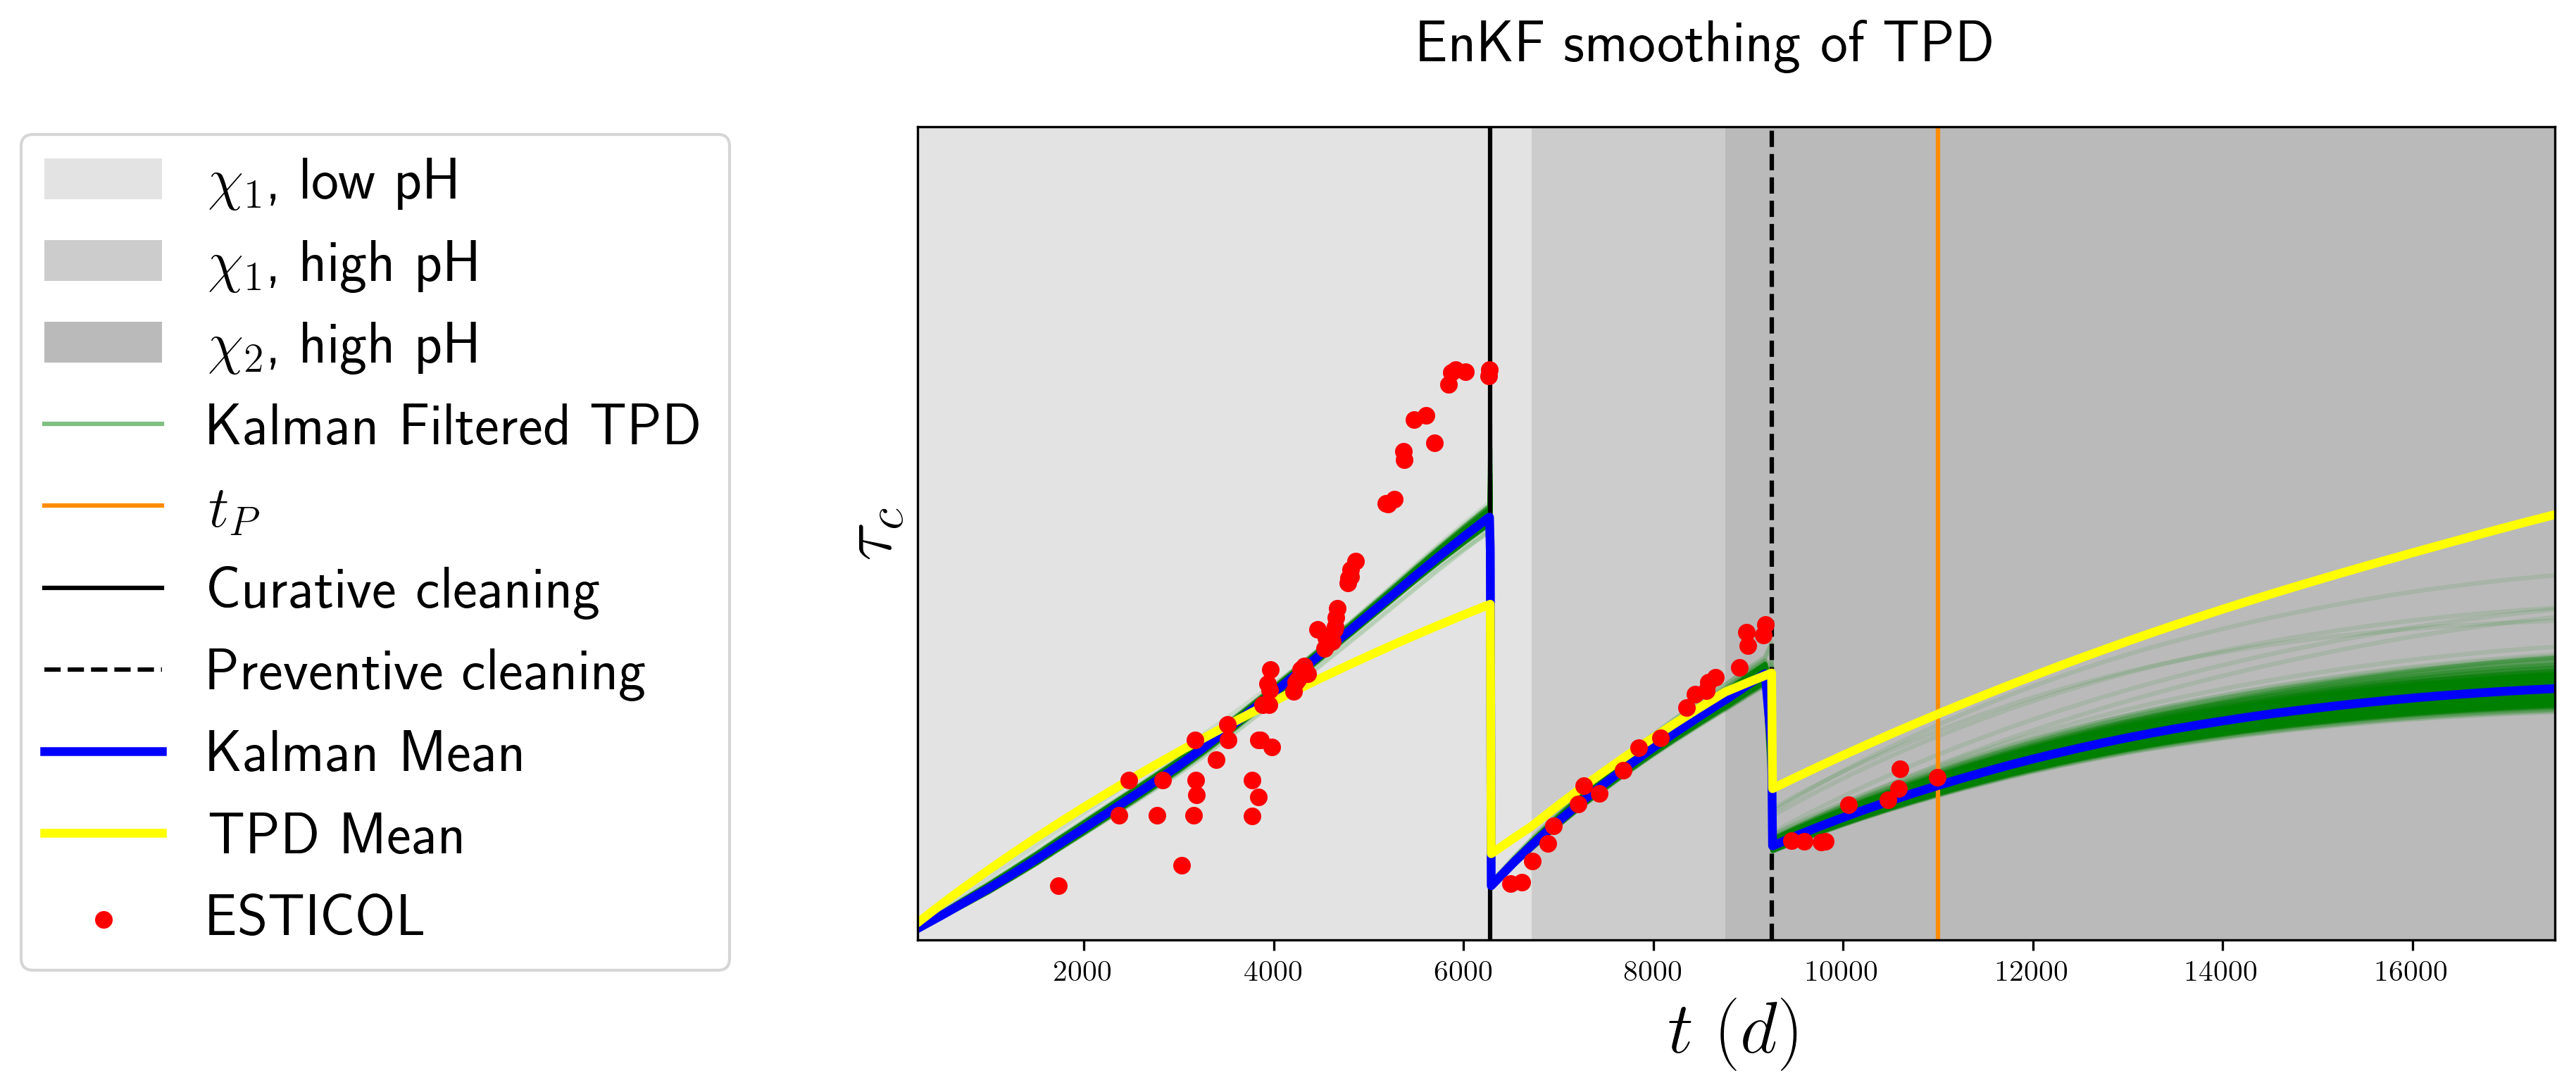

In [60]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs = plot_tpd(axs, input_dic, trajectories, TIME, 'Kalman Filtered TPD')
axs.plot(TIME, np.mean(trajectories, axis=0), color='blue', linewidth=3, label='Kalman Mean')
axs.plot(SIMULATION_TIME, np.mean(y, axis=0), color='yellow', linewidth=3, label='TPD Mean')
for i in range(3):
    if i == 0:
        axs.scatter(obs_indices[i], obs_values[i], color='red', s=25, zorder=10, label='ESTICOL')
    else:
        axs.scatter(obs_indices[i], obs_values[i], color='red', s=25, zorder=10)
axs.grid(False)
axs.set_yticks([])

lines_labels = [axs.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

fig.suptitle(f'EnKF smoothing of TPD', fontsize=20)

# RUL visualization in PC

In [61]:
nc2 = np.where((TIME*24).astype(int) == 221928)[0][0]
pc_time = TIME[nc2+1:]
C = 30

In [62]:
prior_sample = np.asarray(prior.getSample(N))
posterior_sample = np.asarray(posterior_distrib_dfs[2])

In [63]:
#trajectories with prior distribution
first_traj = full_metamodel.predict(SCALER.transform(prior_sample))
first_trajectories = np.asarray([np.interp(pc_time, SIMULATION_TIME, first_traj[i,:]) for i in range(len(first_traj))])

#trajectories with posterior distribution
traj = full_metamodel.predict(SCALER.transform(posterior_sample))
prior_trajectories = np.asarray([np.interp(pc_time, SIMULATION_TIME, traj[i,:]) for i in range(len(traj))])

#trajectories with posterior distribution after smoothing
posterior_trajectories = trajectories[:,nc2+1:]


In [ ]:
#Index of the last 
nc2 = np.where((TIME*24).astype(int) == 221928)[0][0]
pc_time = TIME[nc2+1:]
C = 30

In [65]:
first_rul, rul_before, rul_after = [], [], []
for i in range(N):
    for j in range(len(pc_time)):
        if first_trajectories[i,j] > C:
            first_rul.append(pc_time[j] - pc_time[0])
            break
    for j in range(len(pc_time)):
        if prior_trajectories[i,j] > C:
            rul_before.append(pc_time[j] - pc_time[0])
            break
    for j in range(len(pc_time)):
        if posterior_trajectories[i,j] > C:
            rul_after.append(pc_time[j] - pc_time[0])
            break
first_rul = np.asarray(first_rul)
rul_before = np.asarray(rul_before)
rul_after = np.asarray(rul_after)

In [66]:
# Determine the target sample size (minimum of the two arrays)
target_sample_size = max(len(rul_before), len(rul_after), len(first_rul))

# Bootstrap resampling
rul_before_resampled = resample(rul_before, n_samples=target_sample_size, random_state=42)
rul_after_resampled = resample(rul_after, n_samples=target_sample_size, random_state=42)
first_rul_resampled = resample(first_rul, n_samples=target_sample_size, random_state=42)

rul_df_1 = pd.DataFrame({'Prior RUL': first_rul_resampled, 'BMU RUL': rul_before_resampled})
rul_df_2 = pd.DataFrame({'Prior RUL': first_rul_resampled, 'BMU RUL': rul_before_resampled, 'BMU+EnKS RUL': rul_after_resampled})

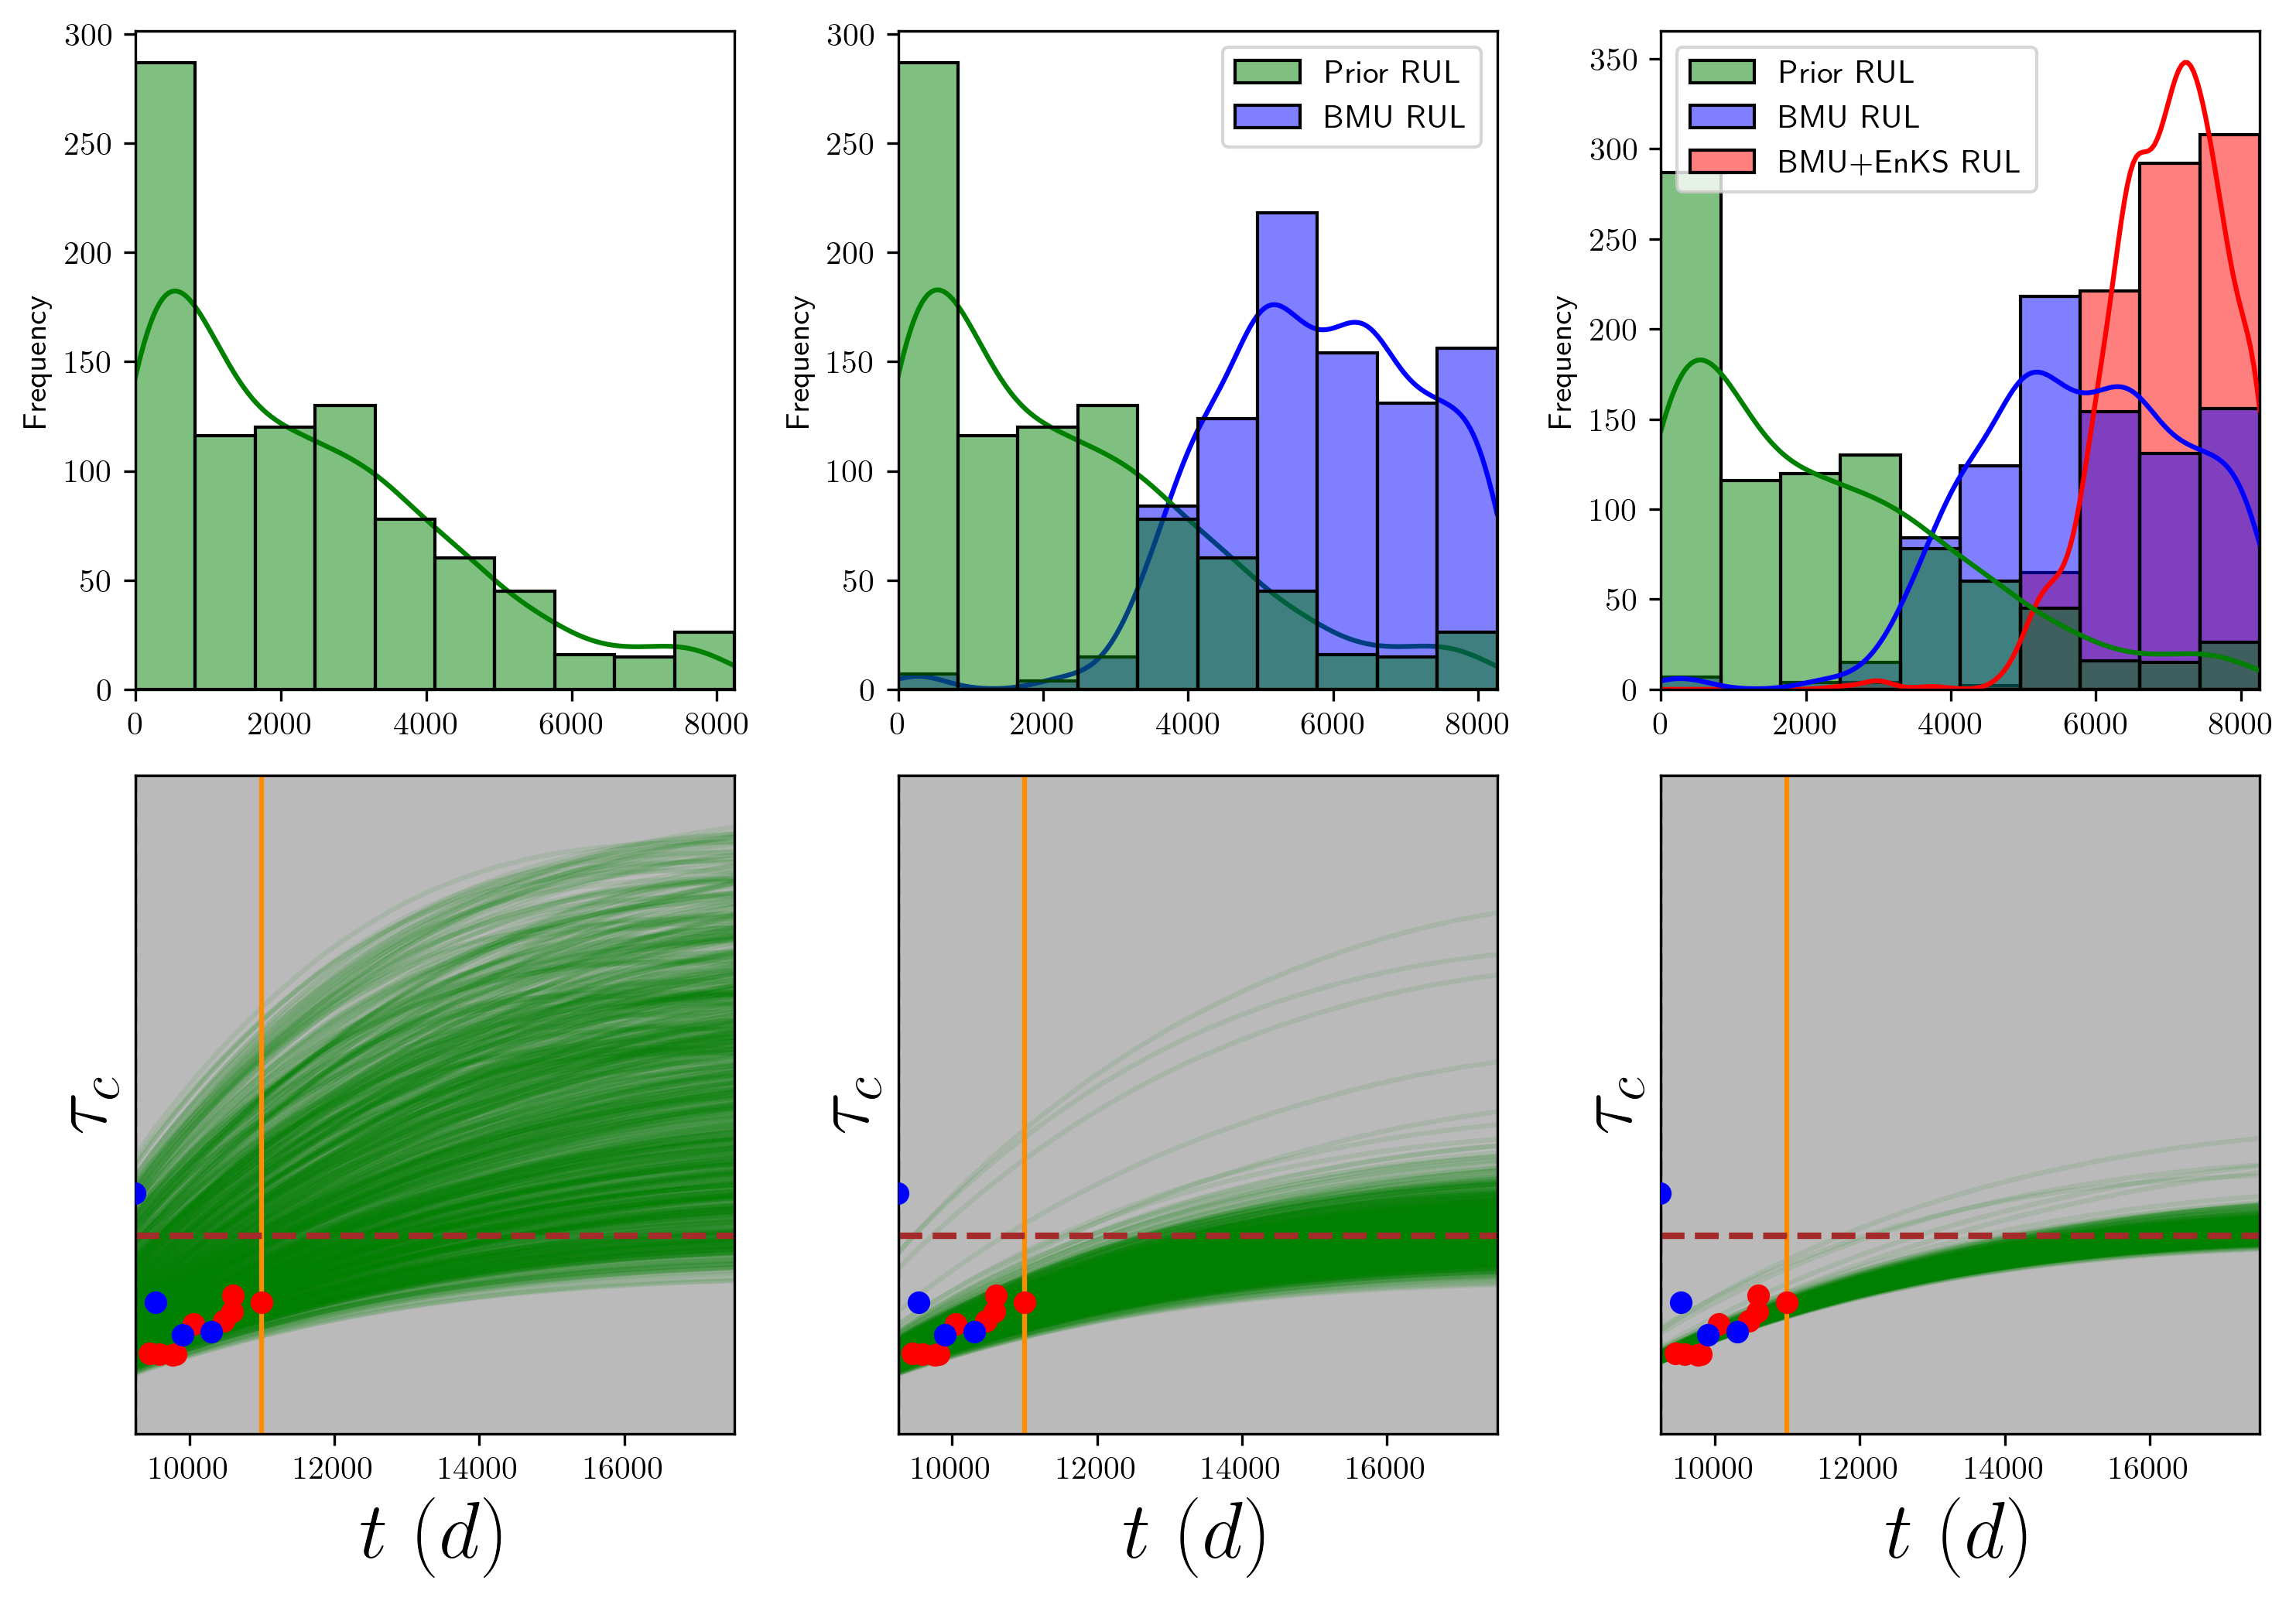

In [72]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

axs[1, 0] = plot_tpd(axs[1, 0], input_dic, first_trajectories, pc_time, 'KLE-TPD')
axs[1, 1] = plot_tpd(axs[1, 1], input_dic, prior_trajectories, pc_time, 'KLE-TPD')
axs[1, 2] = plot_tpd(axs[1, 2], input_dic, posterior_trajectories, pc_time, 'KLE-TPD')

for i in range(3):
    if i == 2:
        axs[1, 0].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs[1, 0].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', label='Field data', zorder=10)
        axs[1, 1].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1, 1].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
        axs[1, 2].scatter(data_with_time_division[i][0][:, 0], data_with_time_division[i][0][:, 1], color='red', zorder=10)
        axs[1, 2].scatter(data_with_time_division[i][1][:, 0], data_with_time_division[i][1][:, 1], color='blue', zorder=10)
    else:
        pass

for ax in axs[1, :]:
    ax.axhline(C, color='brown', linestyle='--', linewidth=2, label=fr'threshold D')
    ax.set_xlim(min(pc_time), max(pc_time))

sns.histplot(rul_df_1['Prior RUL'], ax=axs[0, 0], kde=True, bins=10, color='green', zorder=10)
sns.histplot(rul_df_1, ax=axs[0, 1], kde=True, bins=10, palette=['green','blue'], zorder=30)
sns.histplot(rul_df_2, ax=axs[0, 2], kde=True, bins=10, palette=['green', 'blue','red'], zorder=0)

axs[0, 0].set_xlabel('')
axs[0, 1].set_xlabel('')
axs[0, 2].set_xlabel('')
axs[0, 0].set_ylabel('Frequency')
axs[0, 1].set_ylabel('Frequency')
axs[0, 2].set_ylabel('Frequency')

axs[0, 0].set_xlim(min(rul_df_1['Prior RUL']), max(rul_df_1['Prior RUL']))
axs[0, 1].set_xlim(min(rul_df_1['Prior RUL']), max(rul_df_1['BMU RUL']))
axs[0, 2].set_xlim(min(rul_df_2['Prior RUL']), max(rul_df_2['BMU RUL']))

axs[1, 0].set_yticks([])
axs[1, 1].set_yticks([])
axs[1, 2].set_yticks([])

axs[1, 0].grid(False)
axs[1, 1].grid(False)
axs[1, 2].grid(False)

#lines_labels = [axs[1, 0].get_legend_handles_labels()]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#
#lines[2:] = [line for i, line in enumerate(lines[2:]) if i not in (3, 4)]
#labels[2:] = [label for i, label in enumerate(labels[2:]) if i not in (3, 4)]
#
#fig.legend(lines[2:], labels[2:], bbox_to_anchor=(0.0,0.7), fontsize=20)

#fig.suptitle("KLE-TPD simulations on the prognostics window", fontsize=20)
plt.tight_layout()